In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [13]:
moving_files = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'+f).shape[2] == 100:
        moving_files.append(f)
        
sleeping_files = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'+f).shape[2] == 100:
        sleeping_files.append(f)

In [14]:
len(moving_files), len(sleeping_files)

(2643, 13763)

In [15]:
'0326' not in '180326_003_62_win14_move.npy'

False

In [20]:
import random # deal with imbalance
diff = len(sleeping_files)-len(moving_files)
# for i in range(diff):
#     ind = random.randint(1,len(moving_files)-1)
#     x= moving_files[ind]
#     moving_files.append(x)
    
i = 0
while i < diff:
    ind = random.randint(1,len(moving_files)-1)
    x = moving_files[ind]
    if ('0326' not in x) and ('0328' not in x):
        moving_files.append(x)
        i += 1

In [21]:
len(moving_files), len(sleeping_files)

(13763, 13763)

In [22]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if '0326' not in f if '0328' not in f]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if '0326' in f]
        if mode == 'test':
            self.all_files = [f for f in all_files if '0328' in f]
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0]
        spec = torch.from_numpy(np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  spec.resize(spec.shape[0],100,10), label

In [23]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')
test_dataset  = NoahSpectrogramDataset(mode='test')

In [24]:
len(train_dataset)+len(valid_dataset)+len(test_dataset)

27526

In [25]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 64, shuffle = False)

In [27]:
for batch_idx, (data, labels) in enumerate(train_loader):
    print(data.shape)
    print(data.reshape([data.shape[0],1,-1]).shape)
    print(labels.shape)
    break

torch.Size([64, 62, 100, 10])
torch.Size([64, 1, 62000])
torch.Size([64, 1])


In [28]:
class LogReg(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.resize(x.shape[0],1,10*100*62).float()
        # x = x.reshape([x.shape[0],-1]).float()
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [29]:
def get_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device).float()
            outputs = model(data)
            predictions = []
            for o in outputs:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            # correct += (predictions.flatten() == labels.flatten().numpy()).sum().item()
            correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
    return correct / total

In [30]:
def train(epoch):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        # data = data.reshape([data.shape[0],-1]).float()
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
        
        preds = model(data)
        loss = criterion(preds.reshape(preds.shape[0],-1), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    acc = get_accuracy(train_loader) 
    return epoch_loss,acc

def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            # data = data.reshape([data.shape[0],-1]).float()
            data = data.to(device)
            labels = labels.to(device).float()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            preds = model(data)
            loss = criterion(preds.reshape(preds.shape[0],-1), labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        
    acc = get_accuracy(loader)
    return epoch_loss,acc

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tol = 0.0001
learning_rate = 0.0005
num_epochs = 100

model = LogReg().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # reduced learning rate 

cuda


In [34]:
epochs = []
training_losses = []
training_acc = []
val_losses = []
validation_acc = []
for epoch in range(num_epochs):
    avg_train_loss, train_acc = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_acc = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    if avg_train_loss < tol:
        break

Train loss for epoch 0: 1.6811736822128296
Val loss for epoch 0: 1.490975022315979
Train loss for epoch 1: 0.8690231442451477
Val loss for epoch 1: 1.1403436660766602
Train loss for epoch 2: 0.9365575313568115
Val loss for epoch 2: 1.4240331649780273
Train loss for epoch 3: 0.8249146342277527
Val loss for epoch 3: 1.618625283241272
Train loss for epoch 4: 0.8039190769195557
Val loss for epoch 4: 0.721622109413147
Train loss for epoch 5: 0.7479628920555115
Val loss for epoch 5: 1.131546974182129
Train loss for epoch 6: 0.6541098952293396
Val loss for epoch 6: 1.319098949432373
Train loss for epoch 7: 0.6401951313018799
Val loss for epoch 7: 2.6806013584136963
Train loss for epoch 8: 0.7037199139595032
Val loss for epoch 8: 2.0069916248321533
Train loss for epoch 9: 0.5410113334655762
Val loss for epoch 9: 1.428472876548767
Train loss for epoch 10: 0.6514024138450623
Val loss for epoch 10: 1.3679859638214111
Train loss for epoch 11: 0.5456657409667969
Val loss for epoch 11: 1.95634591579

KeyboardInterrupt: 

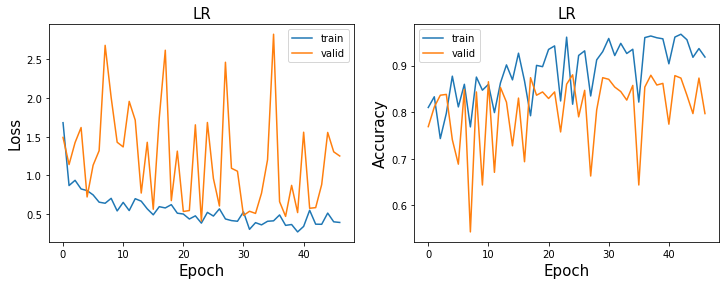

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("LR", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("LR", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

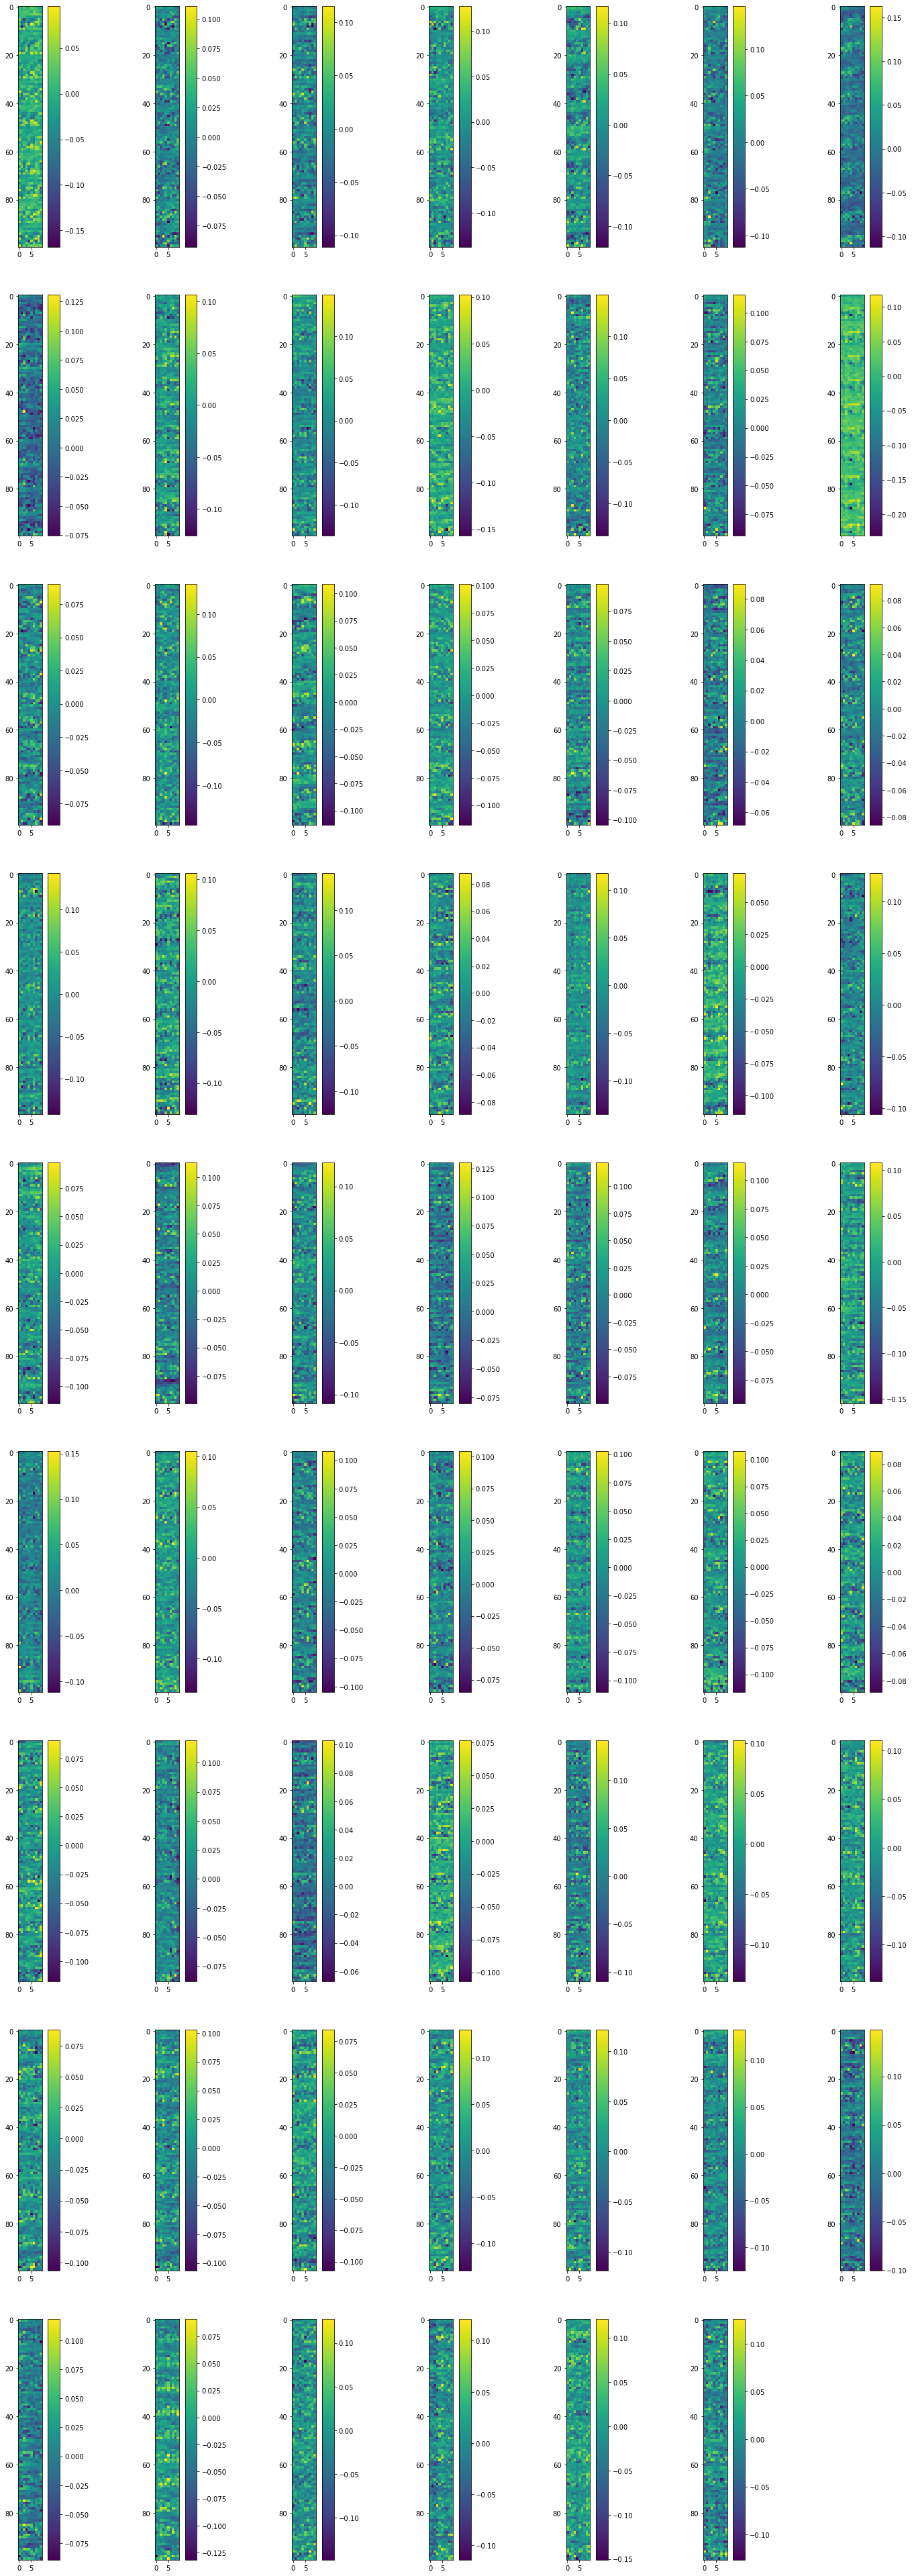

In [58]:
weights = model.linear.weight.view(62, 100, 10)
plt.figure(figsize=(25,70))
for i in range(62):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(9,7,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

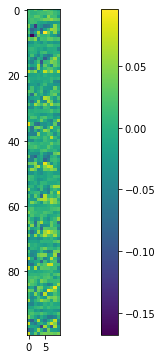

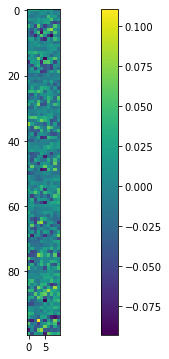

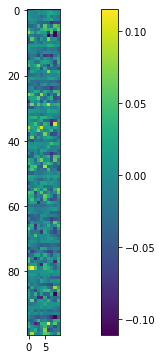

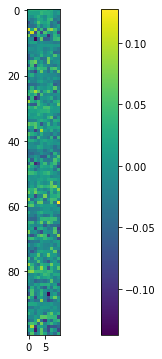

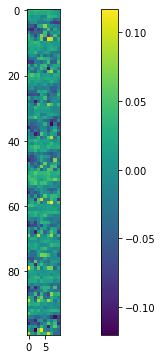

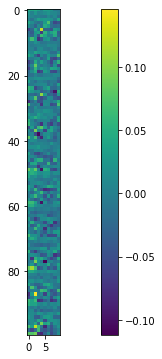

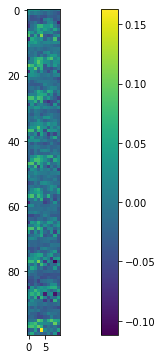

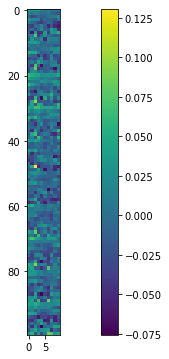

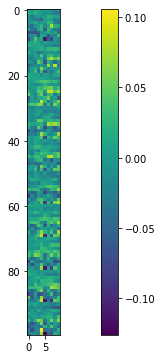

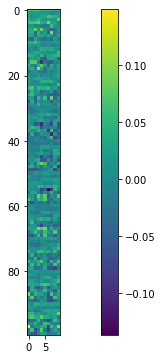

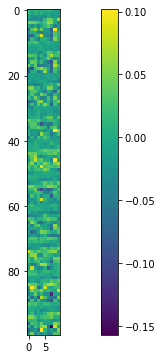

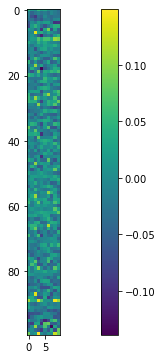

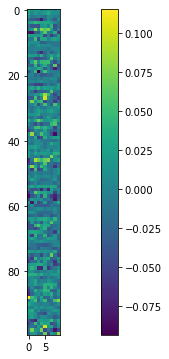

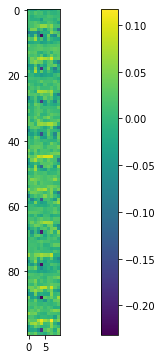

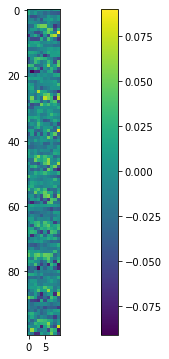

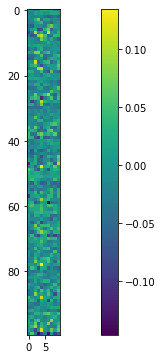

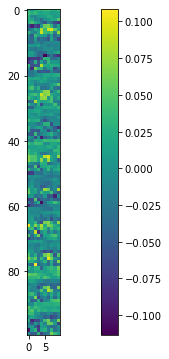

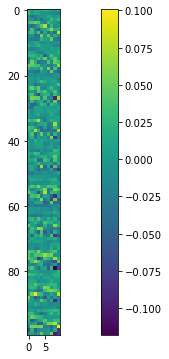

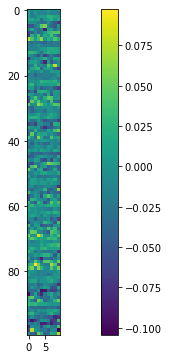

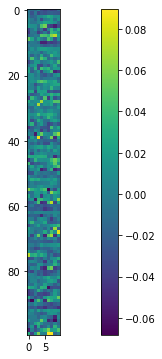

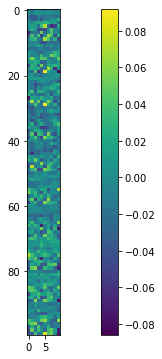

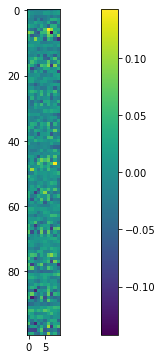

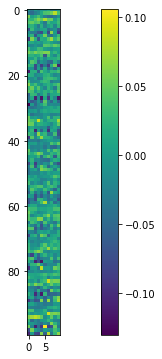

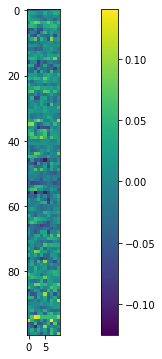

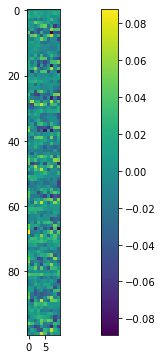

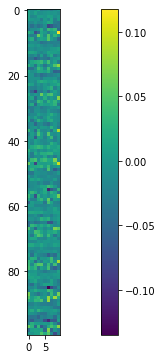

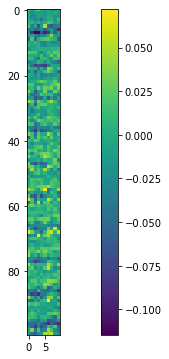

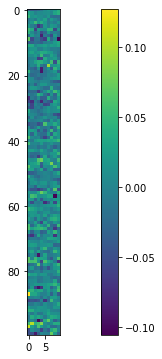

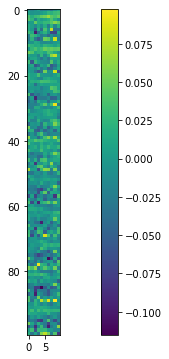

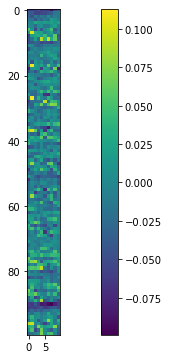

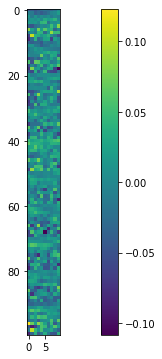

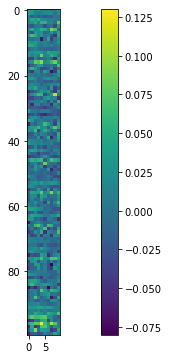

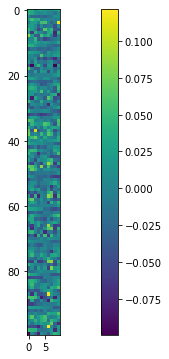

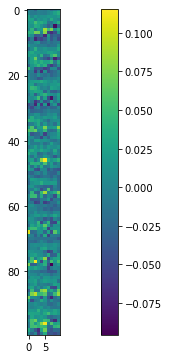

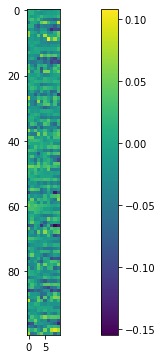

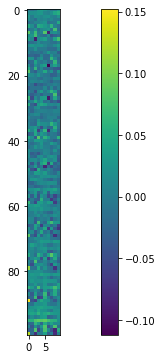

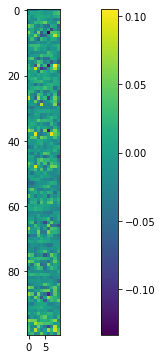

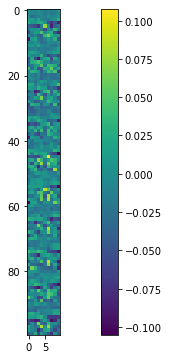

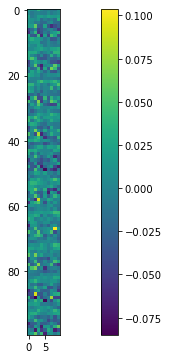

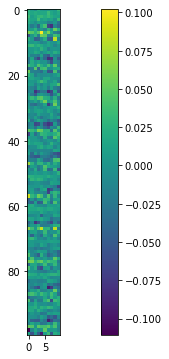

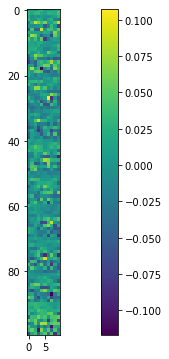

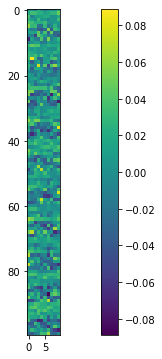

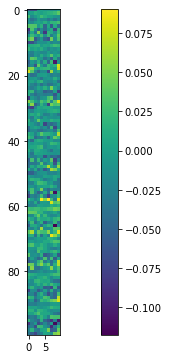

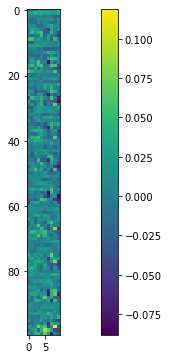

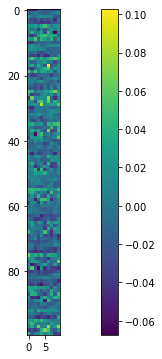

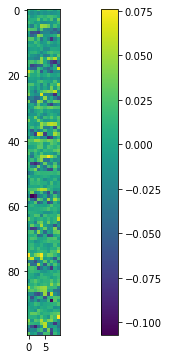

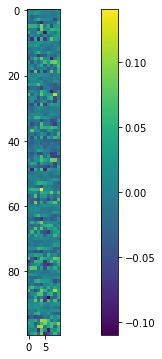

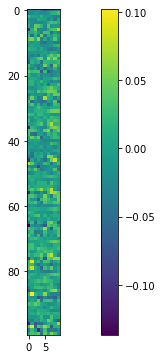

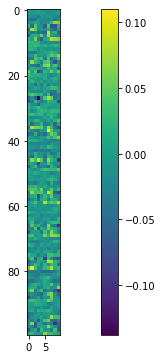

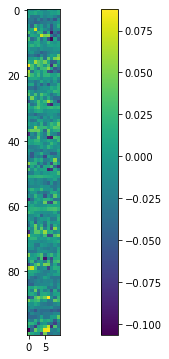

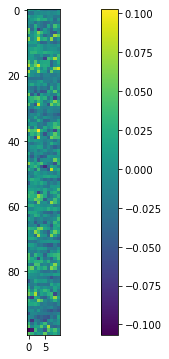

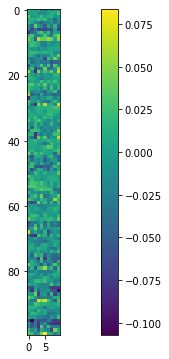

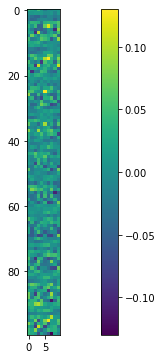

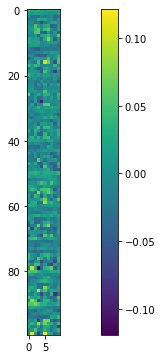

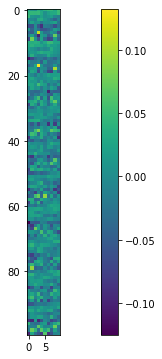

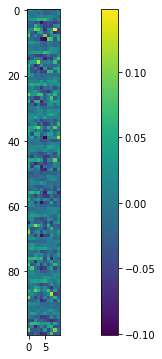

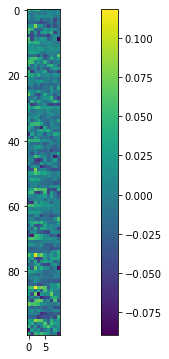

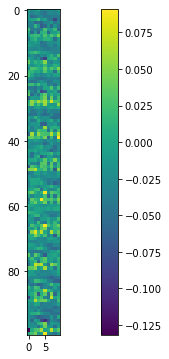

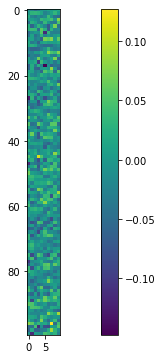

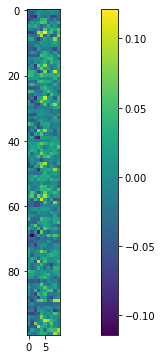

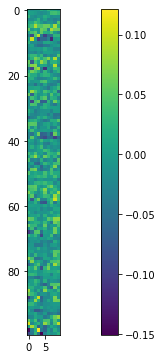

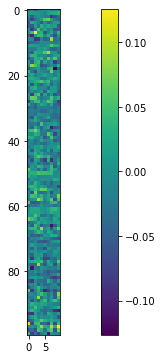

In [61]:
weights = model.linear.weight.view(62, 100, 10)
for i in range(62):
    plt.figure(figsize=(15,6))
    weights_sub = weights[i].detach().cpu()
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
    plt.show()

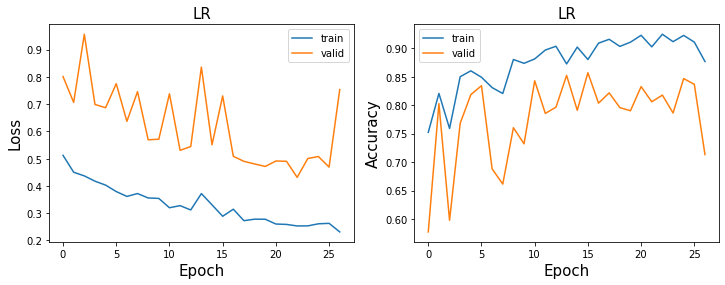

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("LR", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("LR", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [36]:
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/lr_no_reg_1.pt'
torch.save(model.state_dict(), path)

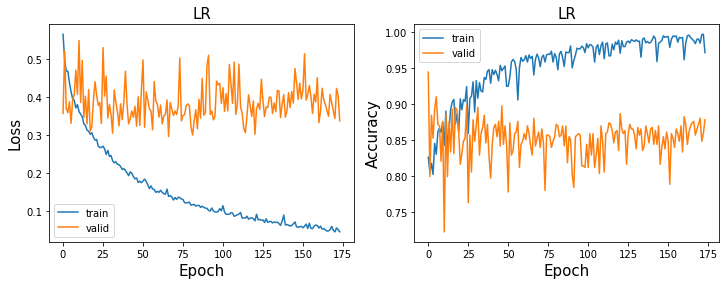

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("LR", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("LR", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

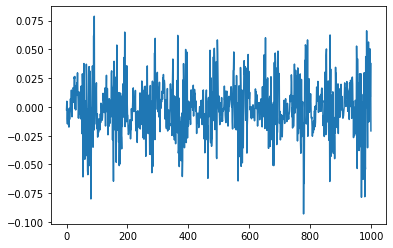

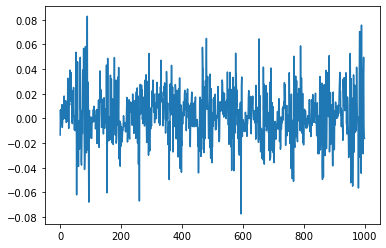

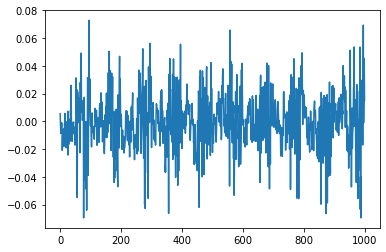

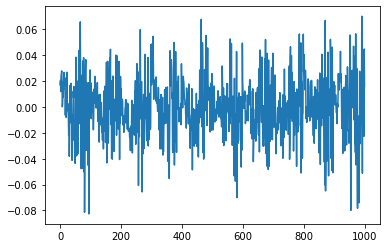

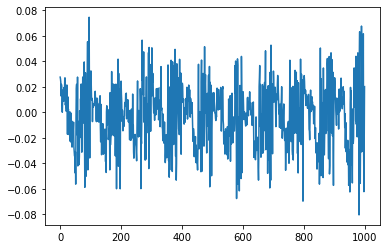

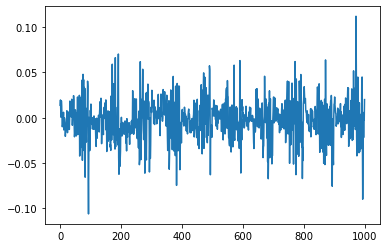

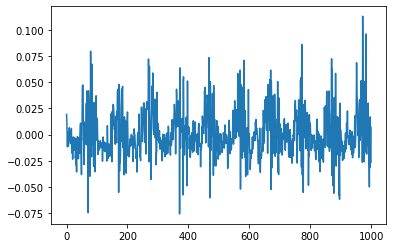

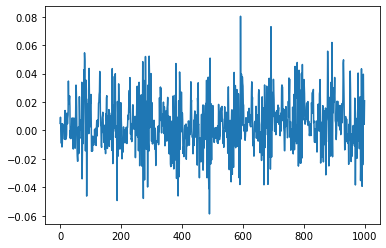

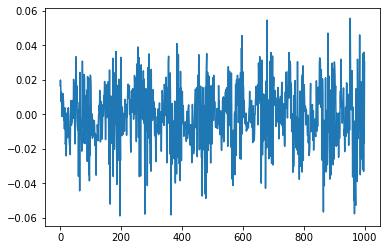

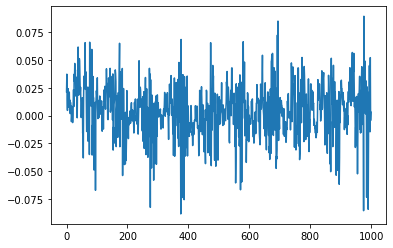

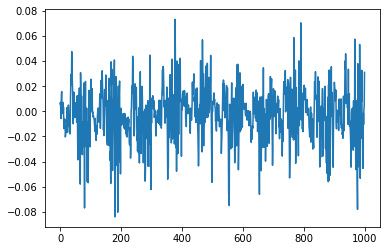

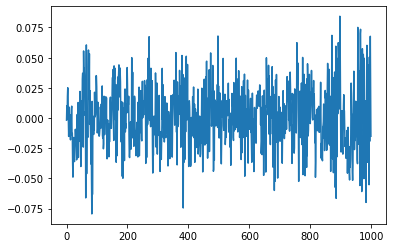

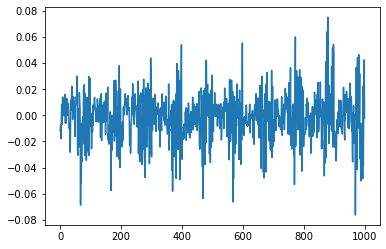

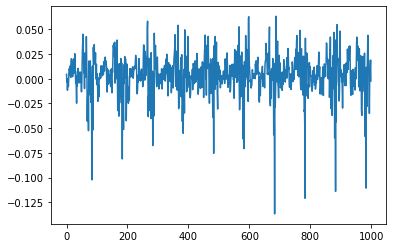

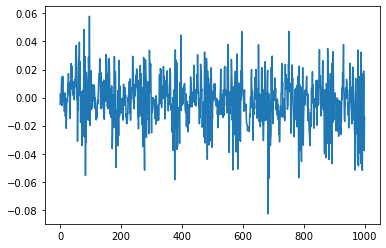

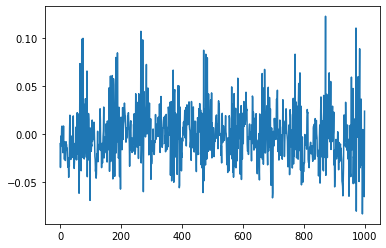

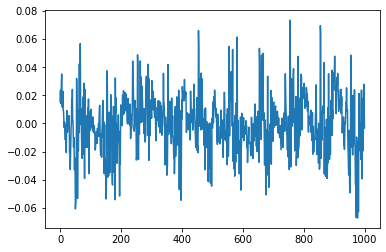

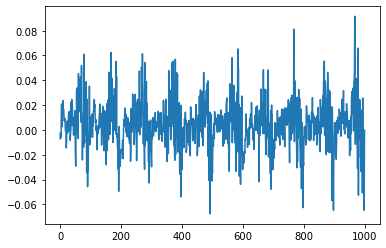

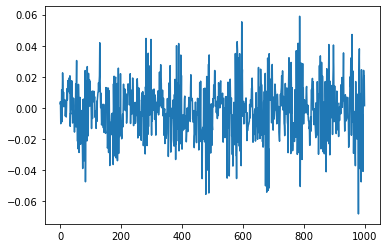

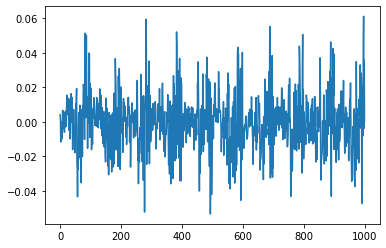

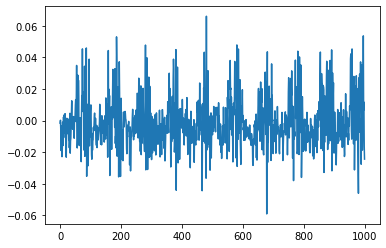

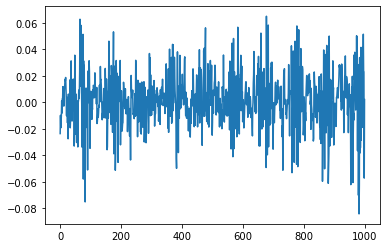

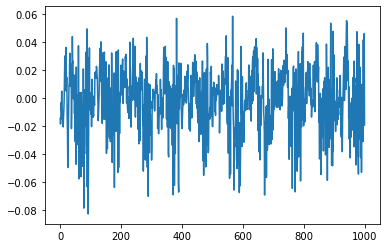

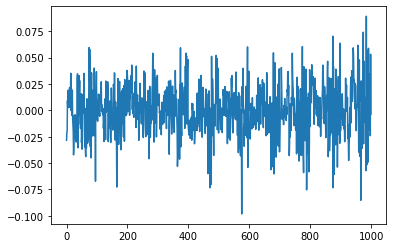

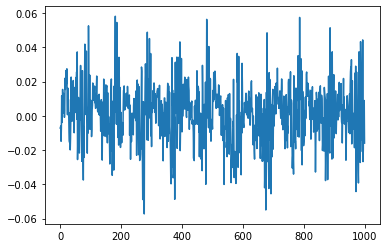

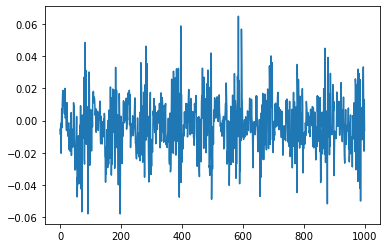

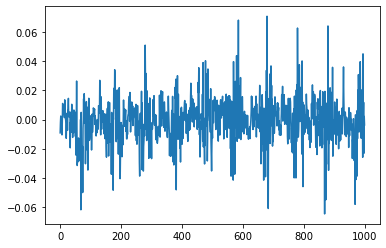

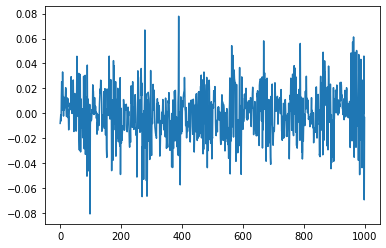

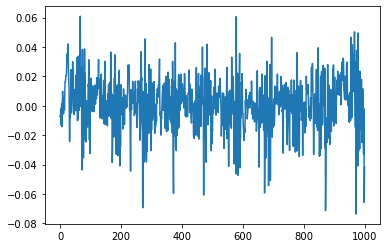

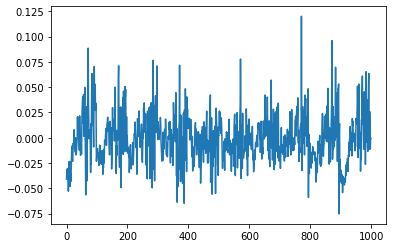

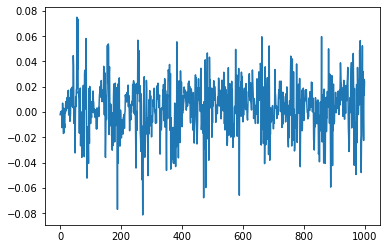

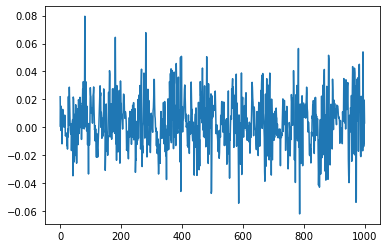

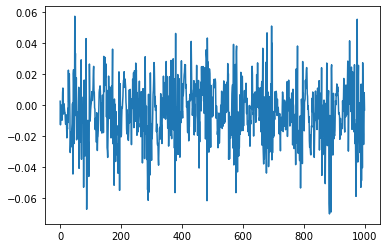

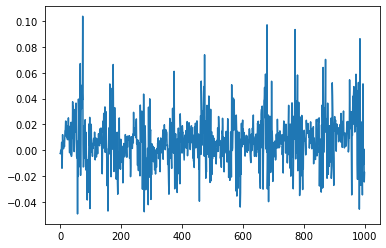

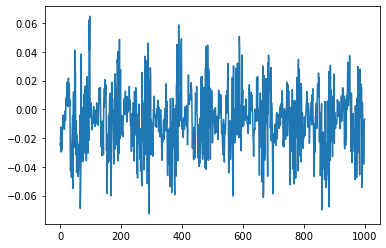

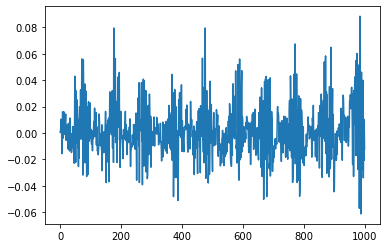

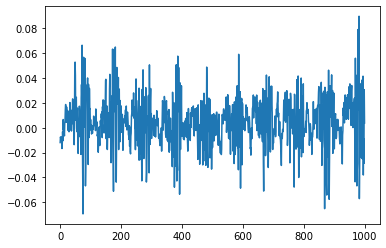

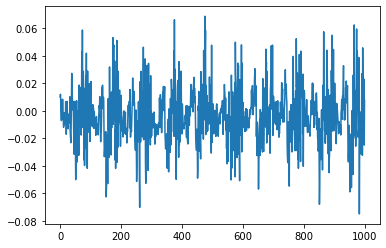

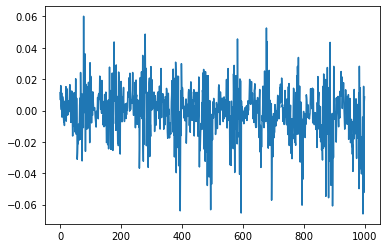

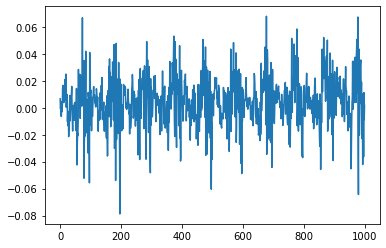

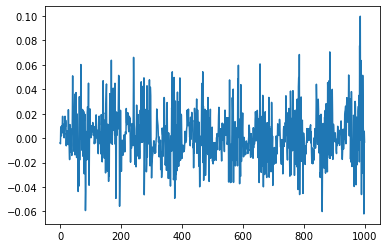

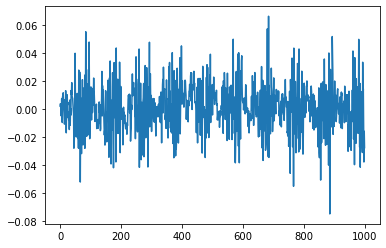

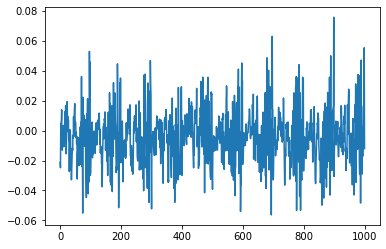

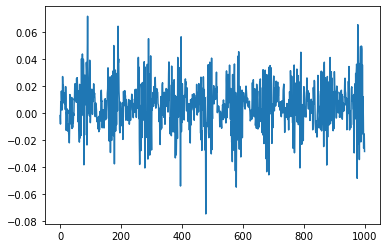

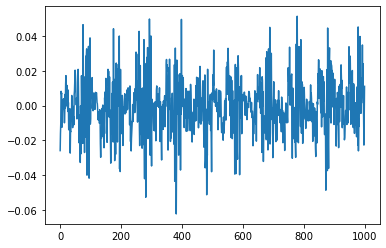

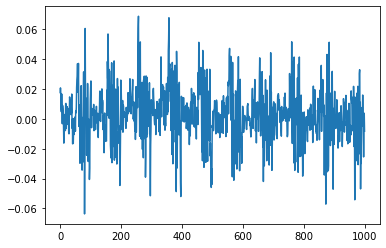

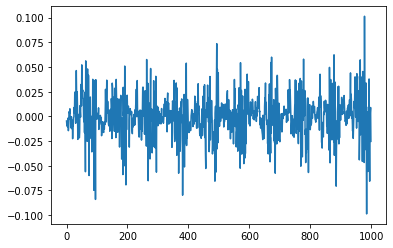

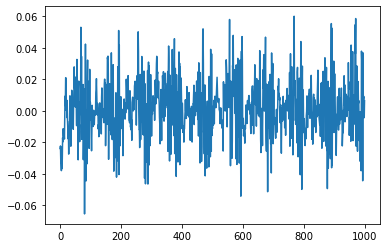

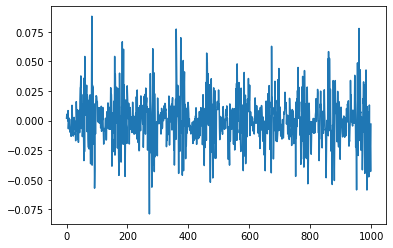

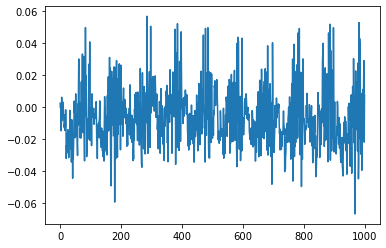

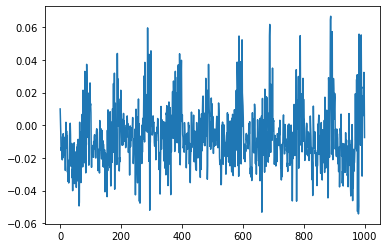

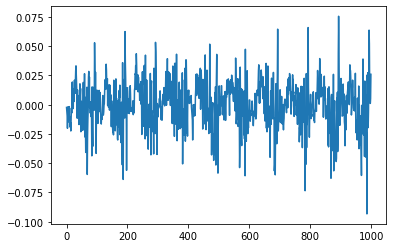

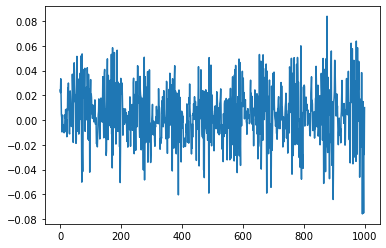

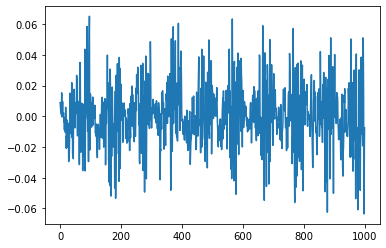

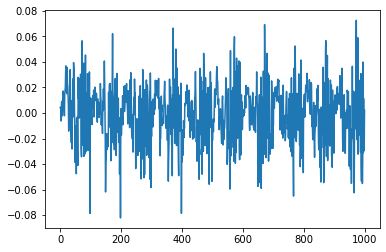

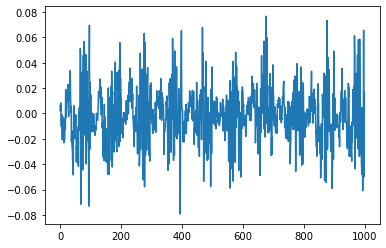

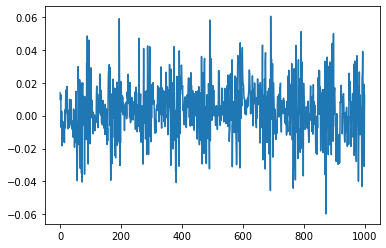

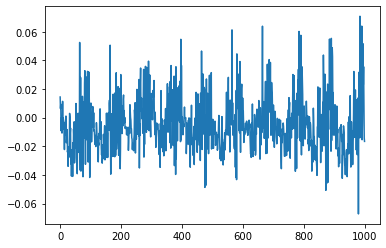

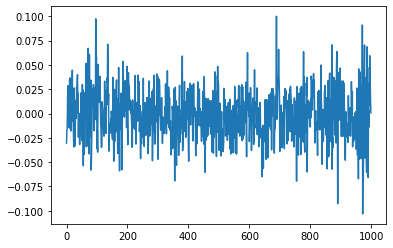

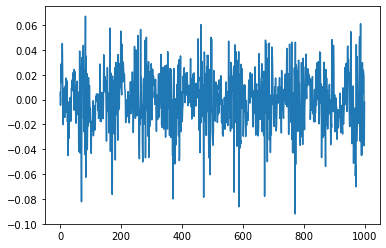

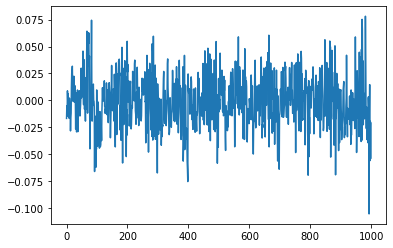

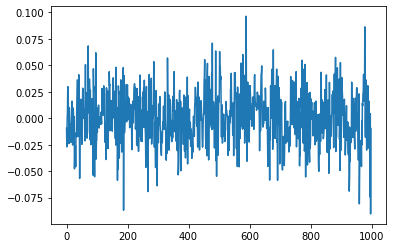

In [33]:
data = model.linear.weight[0].detach().numpy() # reshape 62 times everything left
for i in np.arange(1,62000,1000):
    data_sub = data[i:(i+1000)]
    plt.plot(data_sub)
    plt.show()

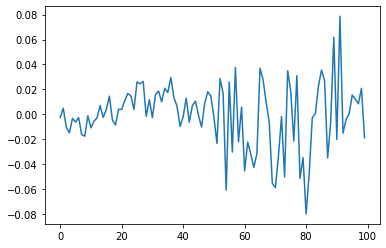

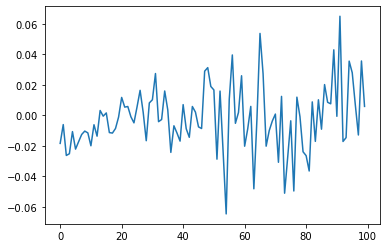

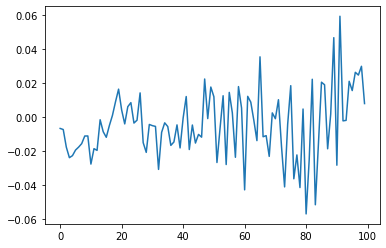

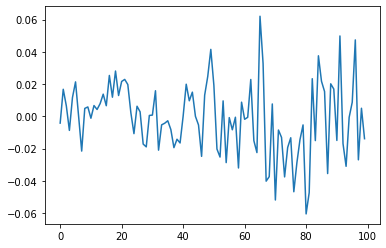

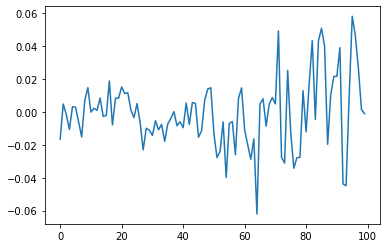

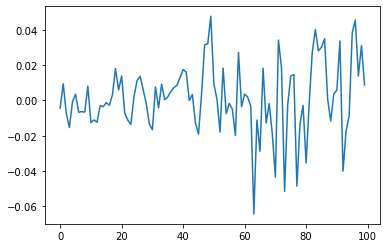

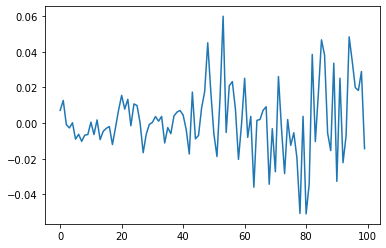

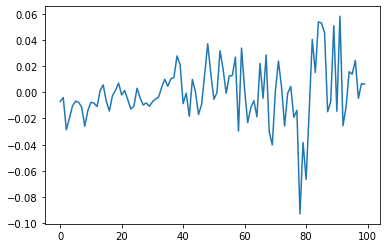

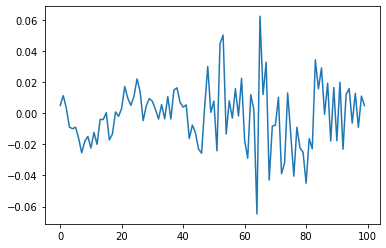

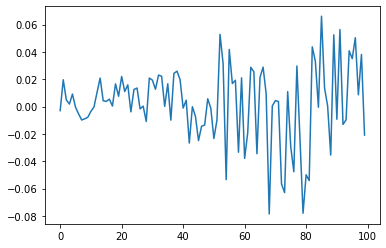

In [34]:
data = model.linear.weight[0].detach().numpy()
for i in np.arange(1,1001,100):
    data_sub = data[i:(i+100)]
    plt.plot(data_sub)
    plt.show()

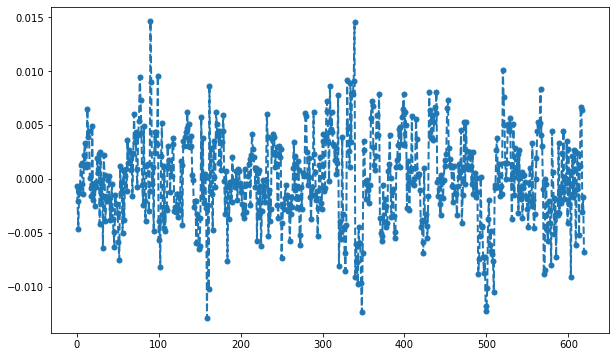

In [59]:
data = model.linear.weight[0].detach().numpy()
data_sub_avg = []
for i in np.arange(1,62000,100):
    data_sub = data[i:(i+100)]
    data_sub_avg.append(np.mean(data_sub))
plt.figure(figsize=(10,6))
plt.plot(range(len(data_sub_avg)), data_sub_avg, 'o--', linewidth=2, markersize=5)
plt.show()

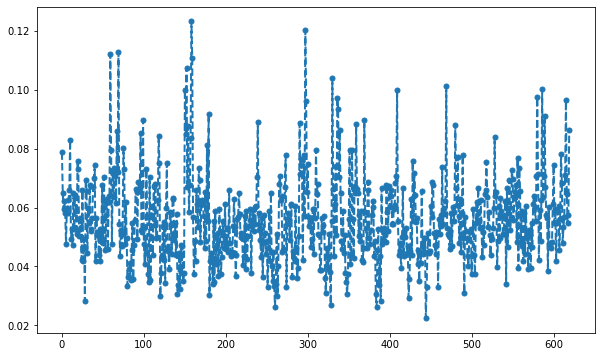

In [60]:
data = model.linear.weight[0].detach().numpy()
data_sub_avg = []
for i in np.arange(1,62000,100):
    data_sub = data[i:(i+100)]
    data_sub_avg.append(np.max(data_sub))
plt.figure(figsize=(10,6))
plt.plot(range(len(data_sub_avg)), data_sub_avg, 'o--', linewidth=2, markersize=5)
plt.show()

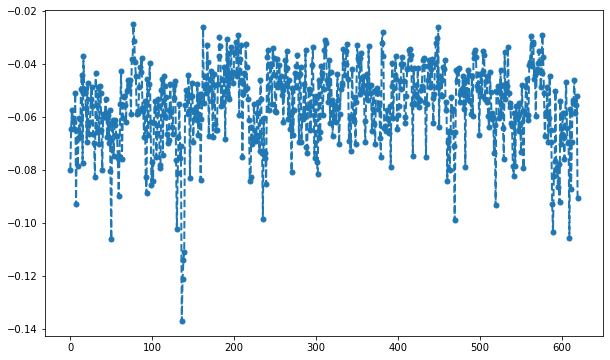

In [61]:
data = model.linear.weight[0].detach().numpy()
data_sub_avg = []
for i in np.arange(1,62000,100):
    data_sub = data[i:(i+100)]
    data_sub_avg.append(np.min(data_sub))
plt.figure(figsize=(10,6))
plt.plot(range(len(data_sub_avg)), data_sub_avg, 'o--', linewidth=2, markersize=5)
plt.show()

l2:0.01, epoch:7, min val loss:0.30462273955345154


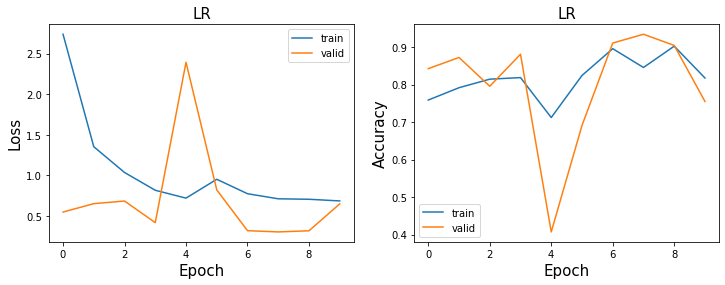

l2:0.1, epoch:6, min val loss:0.34065183997154236


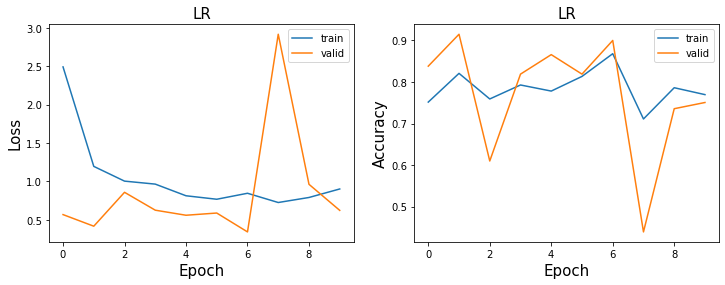

l2:1, epoch:4, min val loss:0.2877177298069


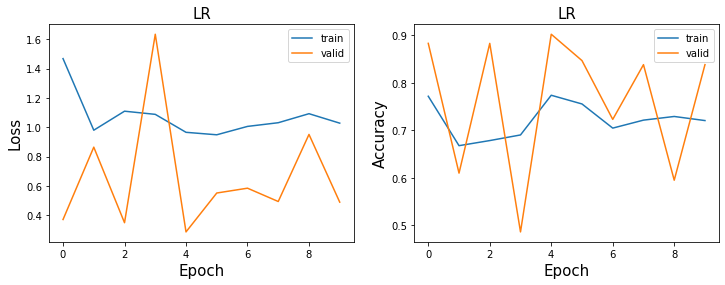

l2:10, epoch:0, min val loss:0.3275150656700134


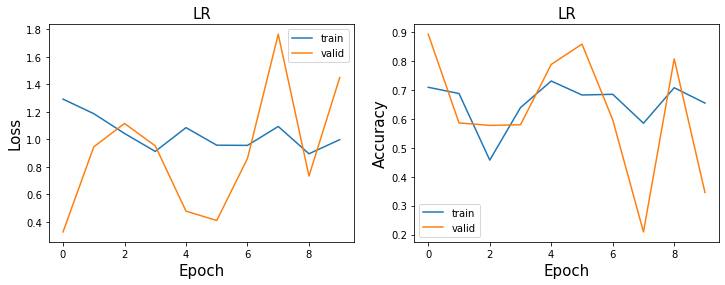

l2:100, epoch:3, min val loss:0.2912382185459137


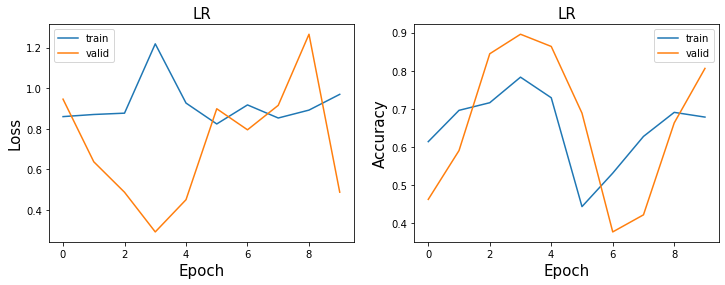

In [109]:
l2_penalty = [0.01, 0.1, 1, 10, 100]
for p in l2_penalty:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LogReg().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=p)
    epochs = []
    training_losses = []
    training_acc = []
    val_losses = []
    validation_acc = []
    for epoch in range(num_epochs):
        avg_train_loss, train_acc = train(epoch)
        val_loss, val_acc = test(val_loader)
        epochs.append(epoch)
        training_losses.append(avg_train_loss)
        training_acc.append(train_acc)
        val_losses.append(val_loss)
        validation_acc.append(val_acc)
    idx = val_losses.index(min(val_losses))
    print('l2:{}, epoch:{}, min val loss:{}'.format(p, idx, min(val_losses)))
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title("LR", fontsize = 15)
    plt.plot(training_losses,linewidth = 1.5,label = 'train')
    plt.plot(val_losses,linewidth = 1.5,label = 'valid')
    plt.xlabel("Epoch",fontsize = 15)
    plt.ylabel("Loss", fontsize = 15)
    plt.legend()
    plt.subplot(1,2,2)
    plt.title("LR", fontsize = 15)
    plt.plot(training_acc,linewidth = 1.5,label = 'train')
    plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
    plt.xlabel("Epoch",fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend()
    plt.show()

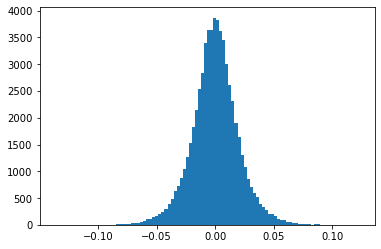

In [31]:
plt.hist(model.linear.weight[0].detach().numpy(), bins=100)
plt.show()

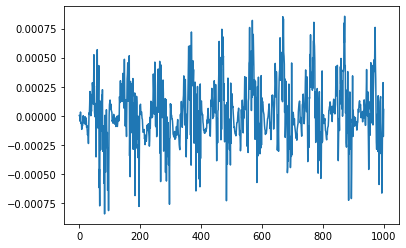

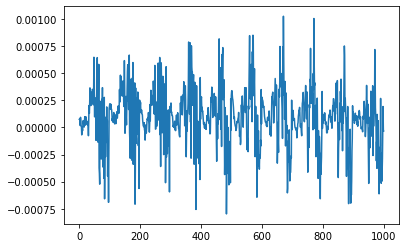

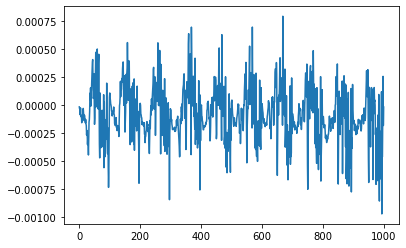

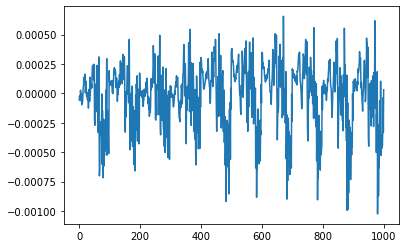

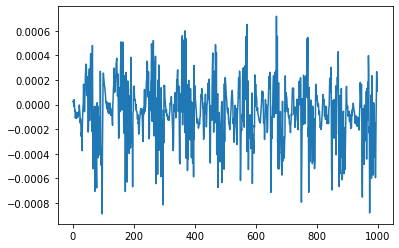

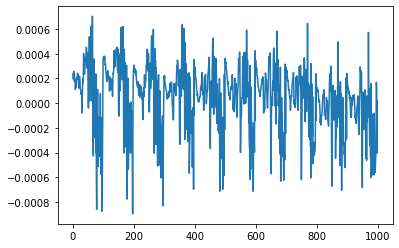

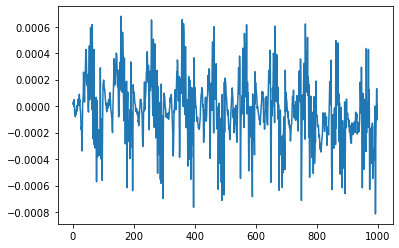

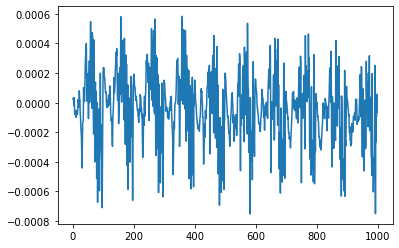

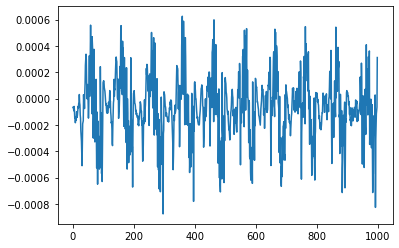

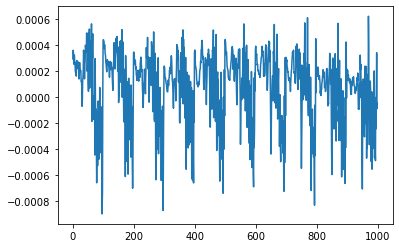

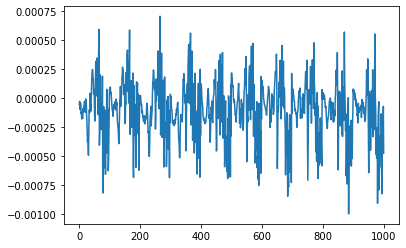

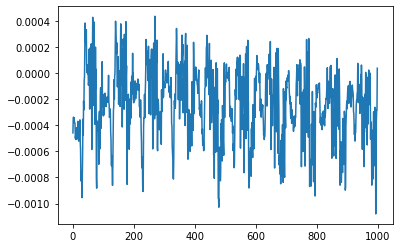

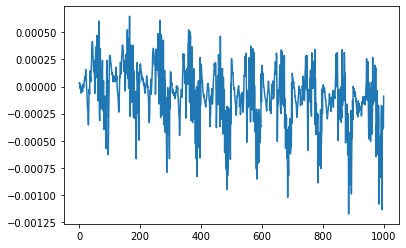

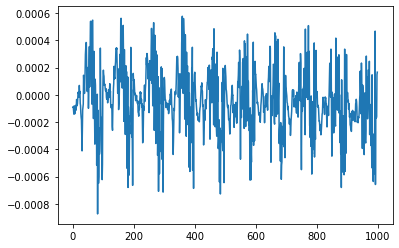

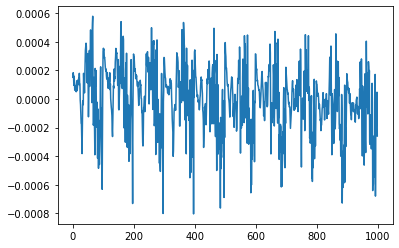

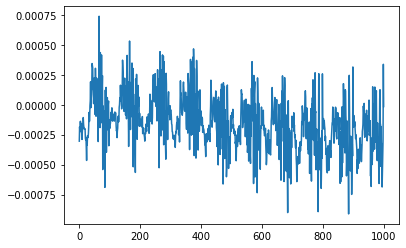

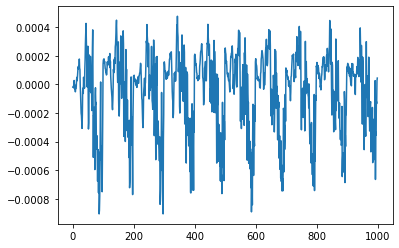

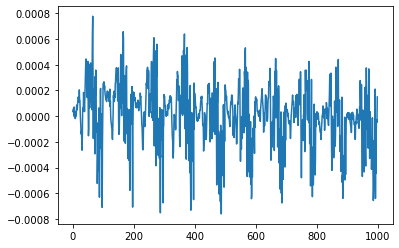

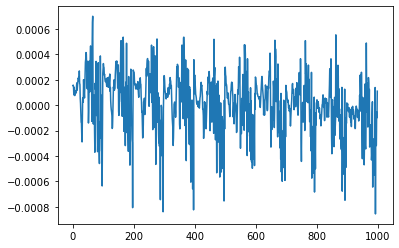

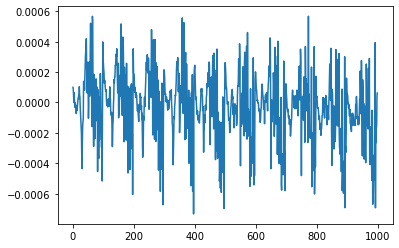

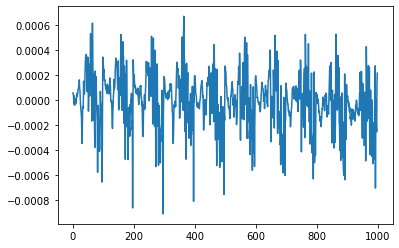

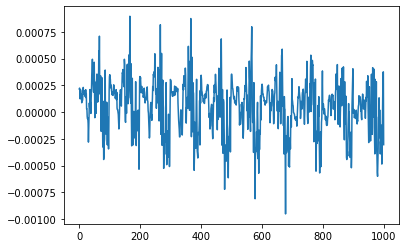

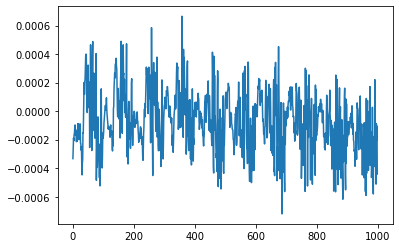

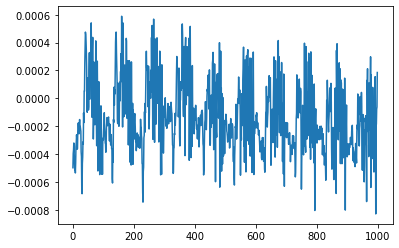

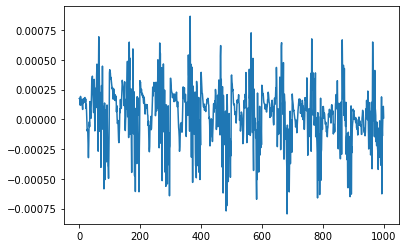

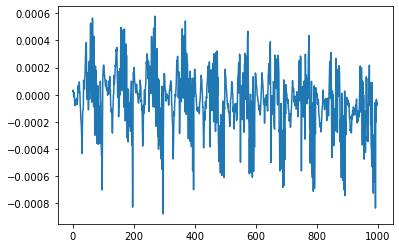

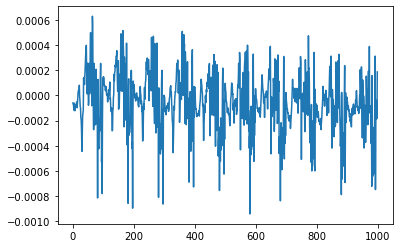

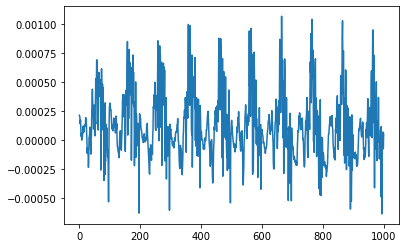

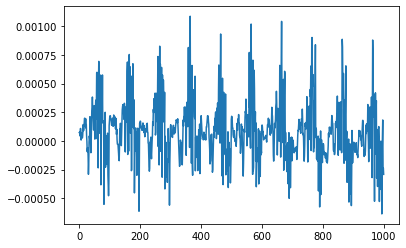

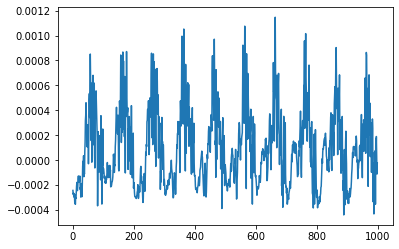

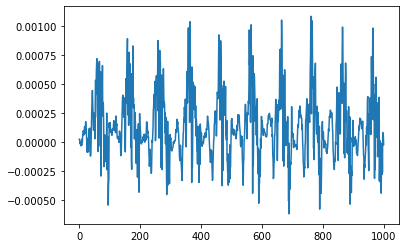

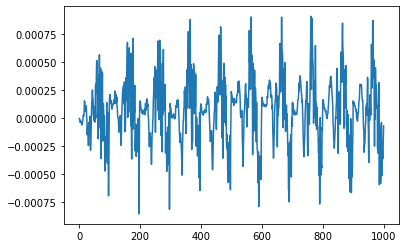

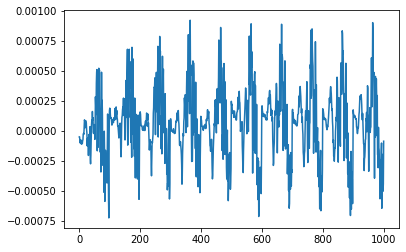

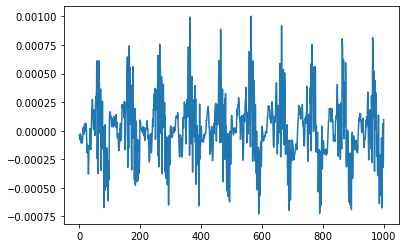

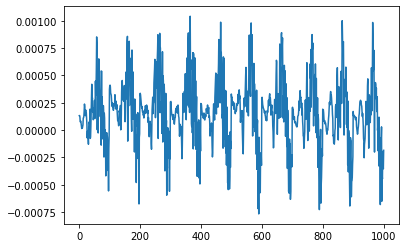

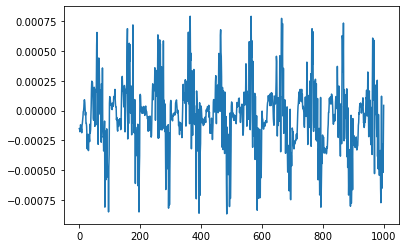

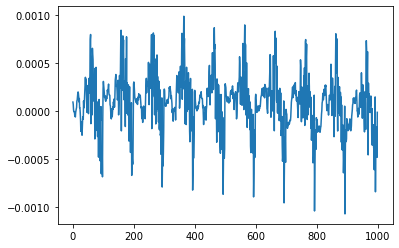

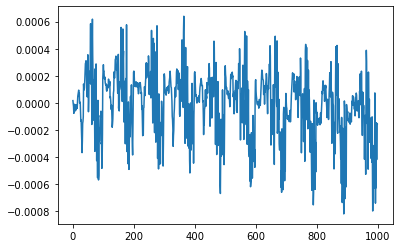

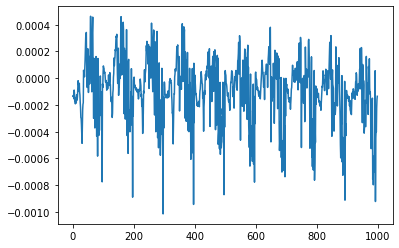

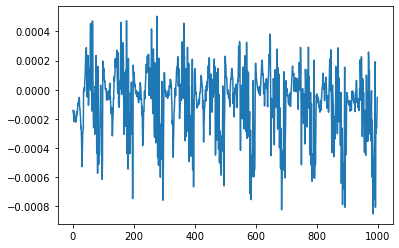

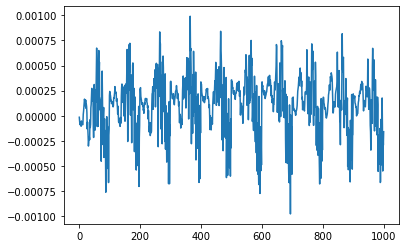

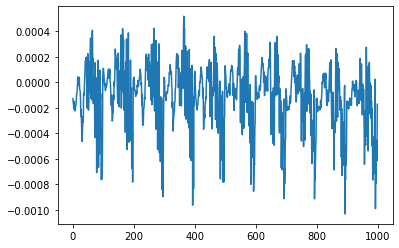

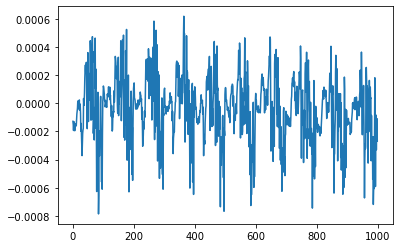

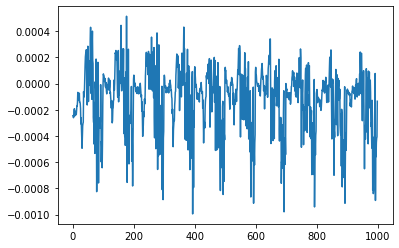

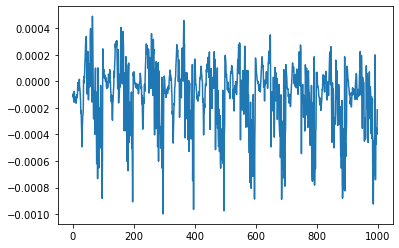

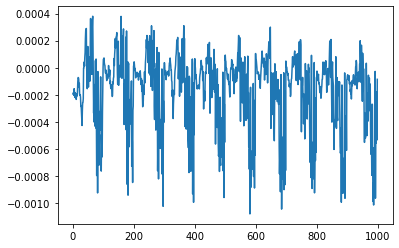

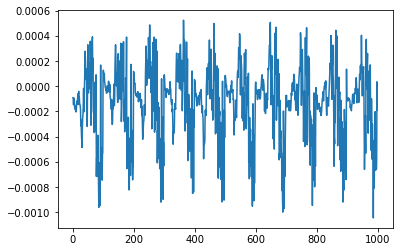

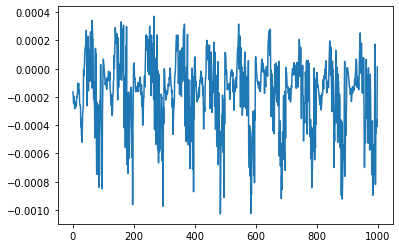

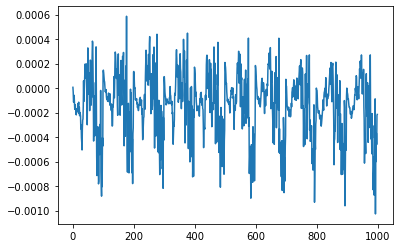

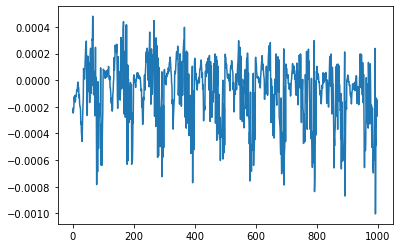

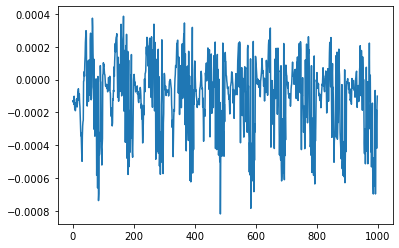

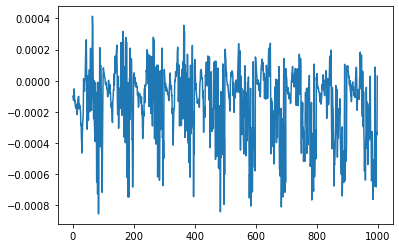

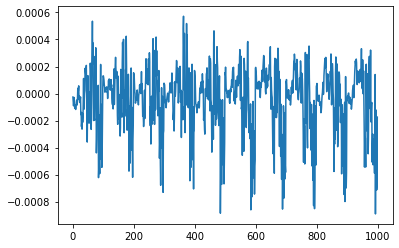

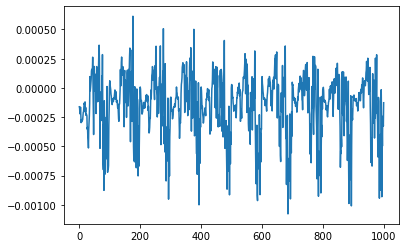

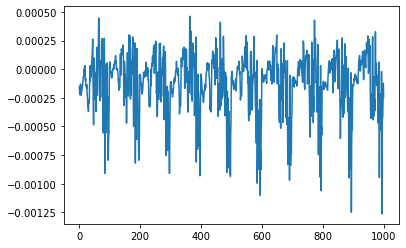

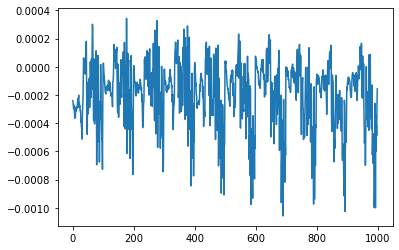

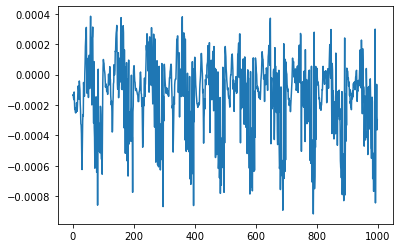

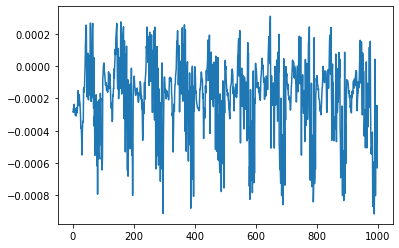

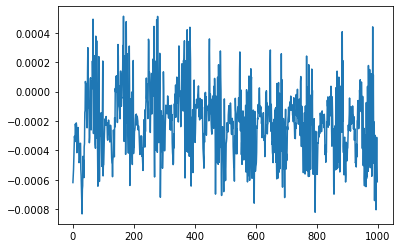

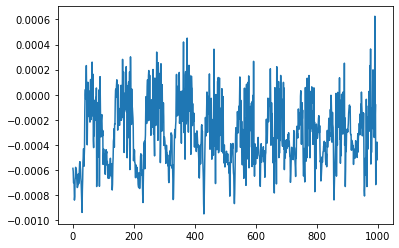

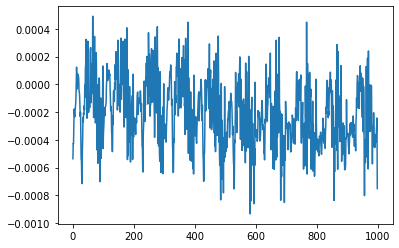

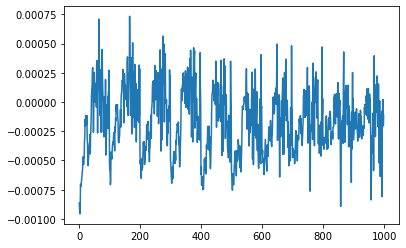

In [134]:
data = model.linear.weight[0].detach().numpy()
for i in np.arange(1,62000,1000):
    data_sub = data[i:(i+1000)]
    plt.plot(data_sub)
    plt.show()

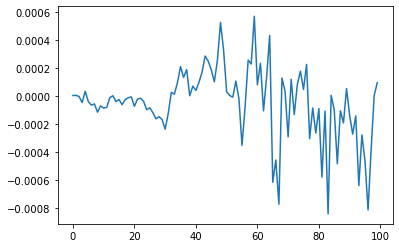

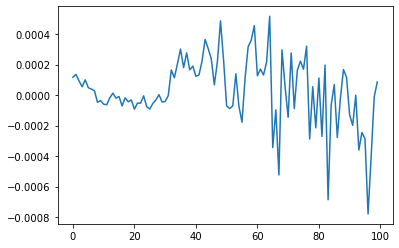

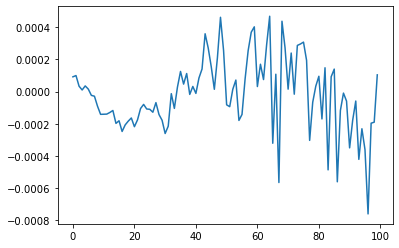

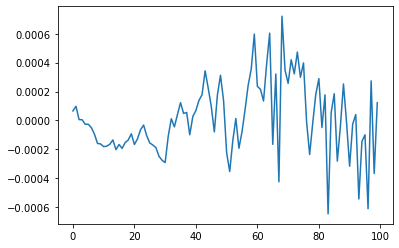

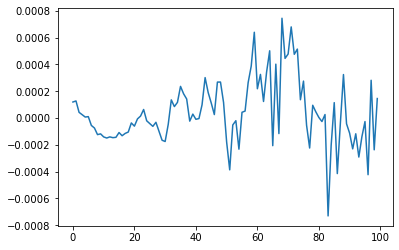

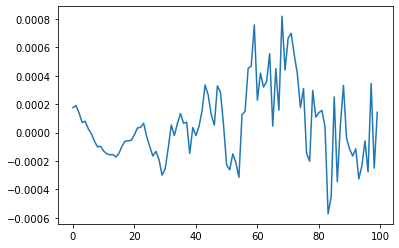

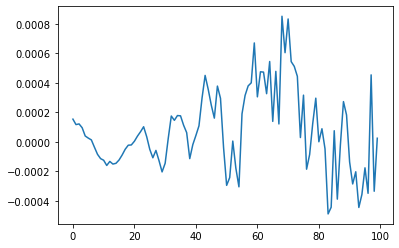

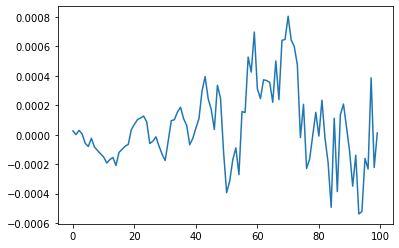

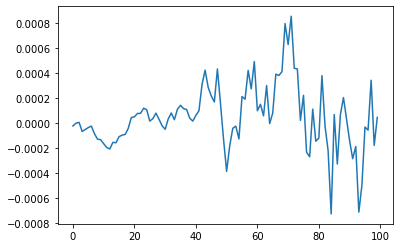

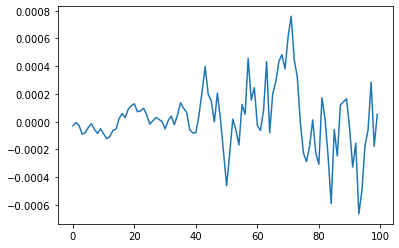

In [137]:
data = model.linear.weight[0].detach().numpy()
for i in np.arange(1,1001,100):
    data_sub = data[i:(i+100)]
    plt.plot(data_sub)
    plt.show()

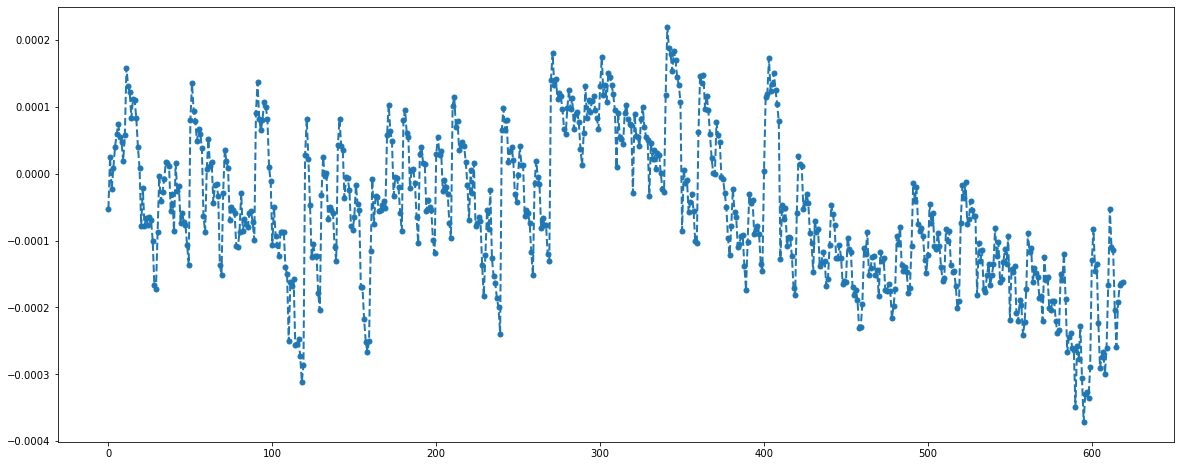

In [154]:
data = model.linear.weight[0].detach().numpy()
data_sub_avg = []
for i in np.arange(1,62000,100):
    data_sub = data[i:(i+100)]
    data_sub_avg.append(np.mean(data_sub))
plt.figure(figsize=(20,8))
plt.plot(range(len(data_sub_avg)), data_sub_avg, 'o--', linewidth=2, markersize=5)
plt.show()

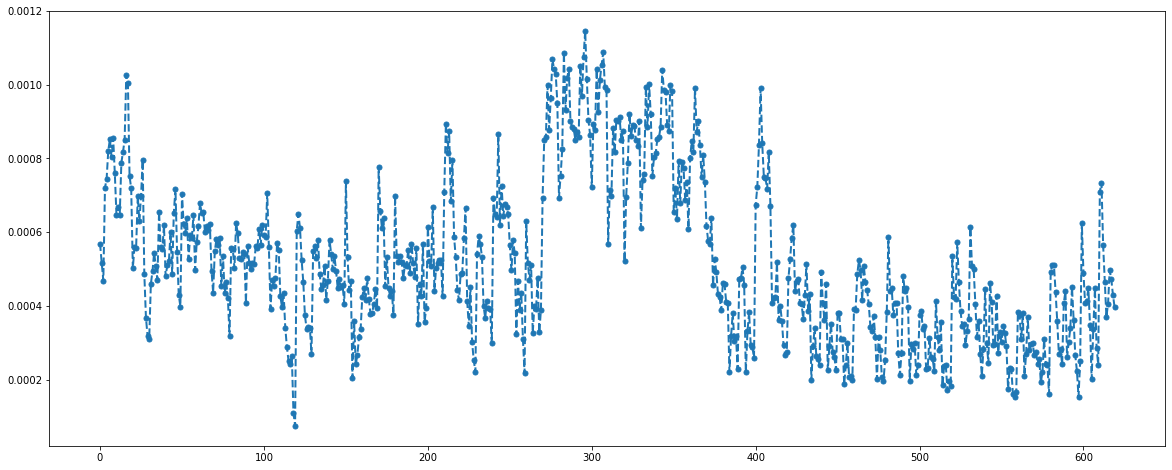

In [155]:
data = model.linear.weight[0].detach().numpy()
data_sub_avg = []
for i in np.arange(1,62000,100):
    data_sub = data[i:(i+100)]
    data_sub_avg.append(np.max(data_sub))
plt.figure(figsize=(20,8))
plt.plot(range(len(data_sub_avg)), data_sub_avg, 'o--', linewidth=2, markersize=5)
plt.show()

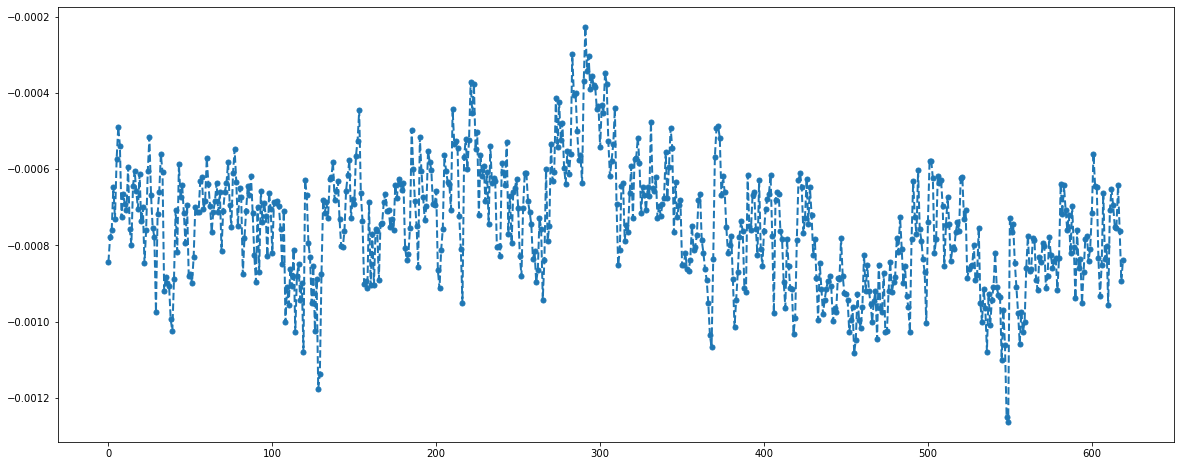

In [158]:
data = model.linear.weight[0].detach().numpy()
data_sub_avg = []
for i in np.arange(1,62000,100):
    data_sub = data[i:(i+100)]
    data_sub_avg.append(np.min(data_sub))
plt.figure(figsize=(20,8))
plt.plot(range(len(data_sub_avg)), data_sub_avg, 'o--', linewidth=2, markersize=5)
plt.show()